In [9]:
import torch.nn as nn
import torch
import torch.utils.data as data
import numpy as np
from tqdm import tqdm
import torch.optim as optim
import os
import scipy.io as sio
from collections import defaultdict, deque
import datetime
import time
import torch.distributed as dist
import errno
import torch.nn.functional as F
import math
import random
from matplotlib import pyplot as plt
from torchvision import transforms

In [10]:
class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{value:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)

class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        if torch.cuda.is_available():
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}',
                'max mem: {memory:.0f}'
            ])
        else:
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}'
            ])
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time),
                        memory=torch.cuda.max_memory_allocated() / MB))
                else:
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time)))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {}'.format(header, total_time_str))


def mkdir(path):
    try:
        os.makedirs(path)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True

In [79]:
# transform
def transform_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    return transform

class channel_dataset_last_layer(data.Dataset):
    def __init__(self, data_path, use_noise: bool = False, is_train: bool = True):
        super(channel_dataset_last_layer, self).__init__()
        self.data_path = data_path
        self.data = sio.loadmat(data_path)
        self.use_noise = use_noise
        self.is_train = is_train
        self.HW_data = np.load(data_path.replace("channel_equal_train.mat", "mlp_layer_1_out_all.npy")) if self.is_train else np.load(data_path.replace("channel_equal_val.mat", "mlp_layer_1_out_all.npy"))
        print(self.HW_data.shape)
        self.trans = transform_data()

        self.tx_data = self.data['Xt_train'] if self.is_train else self.data['Xt_val']
        self.rx_data = self.data['rx_Xt_train'] if self.is_train else self.data['rx_Xt_val']
        self.rx_data_noised = self.data['rx_Xt_noise_train'] if self.is_train else self.data['rx_Xt_noise_val']

        self.tx_data = self.tx_data.astype(np.float32)
        self.rx_data = self.rx_data.astype(np.float32)
        self.rx_data_noised = self.rx_data_noised.astype(np.float32)

        # use min-max normalize to rescale the data to int val of [10, 240]
        self.tx_data = (self.tx_data - np.min(self.tx_data)) / (np.max(self.tx_data) - np.min(self.tx_data)) * 230 + 10
        self.rx_data = (self.rx_data - np.min(self.rx_data)) / (np.max(self.rx_data) - np.min(self.rx_data)) * 230 + 10
        self.rx_data_noised = (self.rx_data_noised - np.min(self.rx_data_noised)) / (np.max(self.rx_data_noised) - np.min(self.rx_data_noised)) * 230 + 10
        self.HW_data = self.HW_data.reshape(-1, 1, 1, 128)
        
        self.tx_data = self.tx_data.astype(np.uint8)
        self.rx_data = self.rx_data.astype(np.uint8)
        self.rx_data_noised = self.rx_data_noised.astype(np.uint8)

        # transfer the tx_data's each element into 7-bits binary digits, as the range is in [0, 128]
        self.tx_data_label = np.unpackbits(self.tx_data, axis=-1)
        self.tx_data_label = self.tx_data_label.reshape(*self.tx_data.shape, -1)
        self.tx_data_label = self.tx_data_label[:, :, 0:].reshape(-1, 64 * 8).astype(float)

        self.tx_pilot, self.tx_data = self.tx_data[:64], self.tx_data[64:].reshape(-1, 8, 8, 1)
        self.rx_pilot, self.rx_data = self.rx_data[:64], self.rx_data[64:].reshape(-1, 8, 8, 1)
        self.rx_pilot_noised, self.rx_data_noised = self.rx_data_noised[:64], self.rx_data_noised[64:].reshape(-1, 8, 8, 1)
        self.tx_data_label_pilot, self.tx_data_label = self.tx_data_label[:64], self.tx_data_label[64:]

        self.tx_pilot = self.tx_pilot[:, :, None]
        self.rx_pilot, self.rx_pilot_noised = self.rx_pilot[:, :, None], self.rx_pilot_noised[:, :, None]

        self.HW_data = self.HW_data[:self.rx_data.shape[0]] if self.is_train else self.HW_data[-self.rx_data.shape[0]:]
        print(self.HW_data.shape)

        self.num_samples = self.tx_data.shape[0]

    def __len__(self):
        return self.num_samples

    def __get_pilot__(self):
        if self.use_noise:
            return self.trans(self.tx_pilot).unsqueeze(0), self.trans(self.rx_pilot_noised).unsqueeze(0)
        else:
            return self.trans(self.tx_pilot).unsqueeze(0), self.trans(self.rx_pilot).unsqueeze(0)

    def __getitem__(self, index):
        if self.use_noise:
            # return self.trans(self.tx_data[index]).view(-1), self.trans(self.HW_data[index]).view(-1)
            return torch.tensor(self.tx_data_label[index]), torch.tensor(self.HW_data[index]).view(-1)
        else:
            # return self.trans(self.tx_data[index]).view(-1), self.trans(self.rx_data[index])
            return torch.tensor(self.tx_data_label[index]), self.trans(self.rx_data[index])


In [85]:
class Equalizer_last_layer(nn.Module):
    def __init__(self, input_size: int = 64, latent_size: int = 64):
        super(Equalizer_last_layer, self).__init__()
        self.equalizer = nn.Sequential(
            nn.Flatten(),
            # nn.ReLU(),
            nn.Linear(128, input_size * 8),
        )

    def forward(self, rx_input):
        equalized_output = rx_input
        equalized_output = self.equalizer(equalized_output)
        return equalized_output

# saperate the last layer into 16 subblocks
class Equalizer_HW_split(nn.Module):
    def __init__(self, input_size: int = 64, latent_size: int = 64):
        super(Equalizer_HW_split, self).__init__()
        self.equalizer = nn.Sequential(
            nn.Flatten(),
            # nn.ReLU(),
            nn.Linear(128, input_size * 8 // 16)
        )

    def forward(self, rx_input):
        equalized_output = rx_input
        equalized_output = self.equalizer(equalized_output)
        return equalized_output

In [86]:
def quantize_regularize(model, device, alpha=0.2):
    central_params = torch.arange(0.0, 1.1, 0.1).to(device)
    reg_params = {}
    for c in central_params:
        if c == 0.0:
            reg_params[c] = [p.abs() < 0.05 for n, p in model.named_parameters()]
        if c == 1.0:
            reg_params[c] = [p.abs() > 0.95 for n, p in model.named_parameters()]
        else:
            reg_params[c] = [(c - 0.05 <= p.abs()) & (p.abs() < c + 0.05) for n, p in model.named_parameters()]

    reg_loss = 0.0
    for c, params in reg_params.items():
        reg_loss += alpha * torch.sum(torch.stack([torch.sum((p[params[i]].abs() - c).abs()) for i, (n, p) in enumerate(model.named_parameters())]))

    return reg_loss

# extract compressed feature
def get_first_layer_output(model, input_tensor):
    first_layer_output = None

    def hook_fn(module, input, output):
        nonlocal first_layer_output
        first_layer_output = output

    # Register hook on the first Linear layer
    hook = model.equalizer[2].register_forward_hook(hook_fn)

    # Forward pass
    model(input_tensor)

    # Remove the hook
    hook.remove()

    # Return the captured output
    return first_layer_output

# train one epoch
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, scaler):
    model.train()
    metric_logger = MetricLogger(delimiter="    ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    # take pilots
    tx_pilot, rx_pilot = data_loader.dataset.__get_pilot__()
    tx_pilot, rx_pilot = tx_pilot.to(device), rx_pilot.to(device)

    # expand pilots among the batch_size dim
    tx_pilot = tx_pilot.expand(data_loader.batch_size, -1, -1, -1)
    rx_pilot = rx_pilot.expand(data_loader.batch_size, -1, -1, -1)

    for tx_input, rx_input in metric_logger.log_every(data_loader, print_freq, header):
        tx_input, rx_input = tx_input.to(device), rx_input.to(device).to(torch.float)

        with torch.amp.autocast('cuda'):
            # equalized_output = model(tx_pilot, rx_pilot, rx_input)
            equalized_output = model(rx_input)
            loss = F.binary_cross_entropy_with_logits(equalized_output, tx_input)

            if epoch >= 100:
                loss += quantize_regularize(model, device)

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        metric_logger.update(loss=loss, lr=optimizer.param_groups[0]["lr"])
        # calculate binary accuracy
        output_bits = (equalized_output > 0).to(torch.uint8)
        accuracy = (output_bits == tx_input.to(torch.uint8)).float().mean()
        metric_logger.update(accuracy=accuracy)

    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    return {k: meter.global_avg for k, meter in metric_logger.meters.items()}

def evaluate(model, data_loader, device, epoch, print_freq):
    model.eval()
    metric_logger = MetricLogger(delimiter="    ")
    header = 'Test: Epoch: [{}]'.format(epoch)

    tx_pilot, rx_pilot = data_loader.dataset.__get_pilot__()
    tx_pilot, rx_pilot = tx_pilot.to(device), rx_pilot.to(device)

    tx_pilot = tx_pilot.expand(data_loader.batch_size, -1, -1, -1)
    rx_pilot = rx_pilot.expand(data_loader.batch_size, -1, -1, -1)
    tx_pilot.requires_grad = False
    rx_pilot.requires_grad = False

    with torch.no_grad():
        with torch.amp.autocast('cuda'):
            for tx_input, rx_input in metric_logger.log_every(data_loader, print_freq, header):
                tx_input, rx_input = tx_input.to(device), rx_input.to(device).to(torch.float)

                # equalized_output = model(tx_pilot, rx_pilot, rx_input)
                equalized_output = model(rx_input)
                loss = F.binary_cross_entropy_with_logits(equalized_output, tx_input)

                metric_logger.update(loss=loss)
                # calculate binary accuracy
                output_bits = (equalized_output > 0).to(torch.uint8)
                accuracy = (output_bits == tx_input.to(torch.uint8)).float().mean()
                metric_logger.update(accuracy=accuracy)

    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    return {k: meter.global_avg for k, meter in metric_logger.meters.items()}

In [87]:
def main(snr):
    # set seed
    torch.manual_seed(42)
    np.random.seed(42)

    batch_size = 256
    num_epoch = 300
    lr = 0.01
    lrf = 0.1

    train_data_path = "./channel_Rayleigh/" + str(snr) + "/PSK16/shuffle/channel_equal_train.mat"
    val_data_path = "./channel_Rayleigh/" + str(snr) + "/PSK16/shuffle/channel_equal_val.mat"

    train_dataset = channel_dataset_last_layer(train_data_path, use_noise=True, is_train=True)
    val_dataset = channel_dataset_last_layer(val_data_path, use_noise=True, is_train=False)

    train_sampler = data.RandomSampler(train_dataset)
    val_sampler = data.SequentialSampler(val_dataset)

    train_loader = data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, drop_last=True)
    val_loader = data.DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler, drop_last=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # model = Equalizer().to(device)
    model = Equalizer_last_layer().to(device)

    params_to_optimize = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(params_to_optimize, lr=lr)
    scaler = torch.amp.GradScaler('cuda')

    lf = lambda x: ((1 + math.cos(x * math.pi / num_epoch)) / 2) * (1 - lrf) + lrf
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)
    scheduler.last_epoch = 0

    best_loss, best_epoch = math.inf, 0
    start_time = time.time()
    for epoch in range(num_epoch):
        train_dict = train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10, scaler=scaler)
        val_dict = evaluate(model, val_loader, device, epoch, print_freq=5)
        scheduler.step()

        if epoch >= 10 and val_dict['loss'] < best_loss:
            best_loss = val_dict['loss']
            best_epoch = epoch
            save_file = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch
            }
            torch.save(save_file, "./channel_Rayleigh/" + str(snr) + "/PSK16/best_model.pth")
            print("Save model from: ", epoch)

    print("Total time: {}s".format(int(time.time() - start_time)))
    print("Best loss: {}".format(best_loss), ";  Best Epoch: {}".format(best_epoch))

    # min, max of the model parameters
    min_params, max_params = [], []
    for p in model.parameters():
        min_params.append(p.min().item())
        max_params.append(p.max().item())
    min_params, max_params = np.min(min_params), np.max(max_params)
    print(f"Min of model parameters: {min_params}, Max of model parameters: {max_params}")
    # plot histogram of model parameters
    params = [p.detach().cpu().numpy().flatten() for p in model.parameters()]
    plt.hist(np.hstack(params), bins=100)
    plt.show()

    return

In [88]:
snr = 20

(9872, 128)
(7936, 1, 1, 128)
(9872, 128)
(1936, 1, 1, 128)
Epoch: [0]    [ 0/31]    eta: 0:00:00    lr: 0.010000    loss: 0.6941 (0.6941)    accuracy: 0.5071 (0.5071)    time: 0.0074    data: 0.0055    max mem: 28
Epoch: [0]    [10/31]    eta: 0:00:00    lr: 0.010000    loss: 0.5925 (0.6335)    accuracy: 0.6765 (0.6480)    time: 0.0059    data: 0.0044    max mem: 28
Epoch: [0]    [20/31]    eta: 0:00:00    lr: 0.010000    loss: 0.5627 (0.6051)    accuracy: 0.6869 (0.6648)    time: 0.0057    data: 0.0042    max mem: 28
Epoch: [0]    [30/31]    eta: 0:00:00    lr: 0.010000    loss: 0.5502 (0.5892)    accuracy: 0.6802 (0.6702)    time: 0.0057    data: 0.0042    max mem: 28
Epoch: [0] Total time: 0:00:00
Averaged stats: lr: 0.010000    loss: 0.5502 (0.5892)    accuracy: 0.6802 (0.6702)
Test: Epoch: [0]    [0/7]    eta: 0:00:00    loss: 0.5572 (0.5572)    accuracy: 0.6703 (0.6703)    time: 0.0041    data: 0.0036    max mem: 28
Test: Epoch: [0]    [5/7]    eta: 0:00:00    loss: 0.5507 (0.55

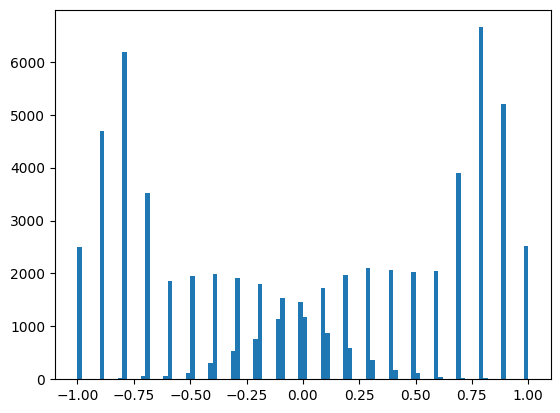

In [89]:
main(snr)

In [ ]:
# visualize a input vector randomly from the dataset, plot the rx, tx and the output equalized rx from model
def visualize_output(model, data_loader, device):
    model.eval()

    random_index = random.randint(0, len(data_loader.dataset) - 1)
    tx_input, rx_input = data_loader.dataset[random_index]
    tx_input, rx_input = tx_input.to(device).unsqueeze(0), rx_input.to(device).unsqueeze(0).to(torch.float)

    with torch.no_grad():
        with torch.amp.autocast('cuda'):
            equalized_output = model(rx_input).sigmoid().round()
            loss = F.mse_loss(equalized_output, tx_input)
    equalized_output = equalized_output.view(-1, 64, 8)
    tx_input = tx_input.view(-1, 64, 8)
    
    equalized_output = torch.sum(equalized_output * (2 ** torch.arange(7, -1, -1, device=device).float()), dim=-1).to(torch.uint8)
    tx_input = torch.sum(tx_input * (2 ** torch.arange(7, -1, -1, device=device).float()), dim=-1).to(torch.uint8)

    tx_input = tx_input.cpu().numpy()
    equalized_output = equalized_output.cpu().numpy()

    plt.figure(figsize=(10, 5))
    plt.plot(tx_input[0], label='tx')
    plt.plot(equalized_output[0], label='calibrated')
    plt.legend()
    plt.show()
    return

def save_compress_data(model, data_loader, device, snr, tx_input, is_train):
    model.eval()
    compress_data = []
    tx_labels = []
    for tx_label, HW_data in data_loader:
        HW_data = HW_data.to(device).to(torch.float)
        with torch.no_grad():
            with torch.amp.autocast('cuda'):
                res = get_first_layer_output(model, HW_data)
                compress_data.append(res.cpu().numpy())
                tx_labels.append(tx_label.cpu().numpy())
    tx_input_label, rx_input = np.vstack(tx_labels), np.vstack(compress_data)
    path = "./channel_Rayleigh/" + str(snr) + "/PSK16/train_rx_input_compresses.npz" if is_train else "./channel_Rayleigh/" + str(snr) + "/PSK16/val_rx_input_compresses.npz"
    np.savez(path, rx_input=rx_input, tx_input=tx_input, tx_input_label=tx_input_label)

# the function to call this visual function
def test(snr):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size = 1
    
    val_data_path = "./channel_Rayleigh/" + str(snr) + "/PSK16/shuffle/channel_equal_val.mat"
    val_dataset = channel_dataset_last_layer(val_data_path, use_noise=True, is_train=False)
    val_sampler = data.SequentialSampler(val_dataset)
    val_loader = data.DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler, drop_last=True)

    train_data_path = "./channel_Rayleigh/" + str(snr) + "/PSK16/shuffle/channel_equal_train.mat"
    train_dataset = channel_dataset_last_layer(train_data_path, use_noise=True, is_train=True)
    train_sampler = data.SequentialSampler(train_dataset)
    train_loader = data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, drop_last=True)
    
    model = Equalizer_last_layer().to(device)
    # model_c = Equalizer_HW_after_CNN().to(device)

    model_path = "./channel_Rayleigh/" + str(snr) + "/PSK16/best_model.pth"
    ckpt = torch.load(model_path)['model']
    # model_c.load_state_dict(ckpt)
    # model_c.eval()
    
    # new_state_dict = {}
    # for k, v in ckpt.items():
    #     print(k)
    #     if "equalizer.1" in k:
    #         continue
    #     elif "equalizer.3" in k:
    #         new_key = k.replace("equalizer.3", "equalizer.1")
    #     elif "equalizer.5" in k:
    #         new_key = k.replace("equalizer.5", "equalizer.3")
    #     new_state_dict[new_key] = v
        
    model.load_state_dict(ckpt)
    model.eval()

    visualize_output(model, val_loader, device)
    # save_compress_data(model_c, train_loader, device, snr, train_dataset.tx_data, True)
    # save_compress_data(model_c, val_loader, device, snr, val_dataset.tx_data, False)
    
    model_HW_splits = [Equalizer_HW_split().to(device) for _ in range(16)]
    
    # Ensure the last layer exists and has the correct shape
    last_layer = list(model.equalizer.children())[-1]
    assert isinstance(last_layer, nn.Linear), "Expected the last layer to be Linear"
    assert last_layer.weight.data.shape[0] % 16 == 0, "Output size not divisible by 16"
    
    for i in range(16):
        # Assign only the last layer's weights and biases to each split model
        model_HW_splits[i].equalizer[-1].weight.data = last_layer.weight.data[i * 32: (i + 1) * 32, :].clone()
        model_HW_splits[i].equalizer[-1].bias.data = last_layer.bias.data[i * 32: (i + 1) * 32].clone()
    
        # If additional layers need loading, do so selectively
        for j, (split_layer, model_layer) in enumerate(zip(model_HW_splits[i].equalizer.children(), model.equalizer.children())):
            if j != len(model.equalizer) - 1:  # Skip the last layer
                split_layer.load_state_dict(model_layer.state_dict())


    # min, max of the model parameters
    min_params, max_params = [], []
    for p in model.parameters():
        min_params.append(p.min().item())
        max_params.append(p.max().item())
    min_params, max_params = np.min(min_params), np.max(max_params)
    print(f"Min of model parameters: {min_params}, Max of model parameters: {max_params}")
    # plot histogram of model parameters
    params = [p.detach().cpu().numpy().flatten() for p in model.parameters()]
    # plt.figure(figsize=(10, 5))
    # plt.hist(np.hstack(params), bins=100)
    # plt.show()

    dummy_input = torch.randn(1, 1, 1, 128).to(device)
    torch.onnx.export(model, dummy_input,
                      "./channel_Rayleigh/" + str(snr) + "/PSK16/model_after_CNN.onnx",
                      export_params=True, opset_version=16, dynamic_axes={'input': {0: 'batch_size'}, 'sensor_out': {0: 'batch_size'}},
                      input_names=['input'], output_names=['sensor_out'])

    for i in range(16):
        path = "./channel_Rayleigh/" + str(snr) + "/PSK16/split_model_no_CNN/"
        if not os.path.exists(path):
            os.makedirs(path)
        torch.onnx.export(model_HW_splits[i], dummy_input,
                          "./channel_Rayleigh/" + str(snr) + "/PSK16/split_model_no_CNN/best_model_HW_{}.onnx".format(i),
                          export_params=True, opset_version=16, dynamic_axes={'input': {0: 'batch_size'}, 'sensor_out': {0: 'batch_size'}},
                          input_names=['input'], output_names=['sensor_out'])
    return model

model = test(snr)
for p in model.parameters():
    print(p.mean(), p.std())